In [23]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge
from utils import calculate_metric

# Set random seed for reproducibility
np.random.seed(42)

## Load Data

Load train and test predictions from base models, as well as the target labels.

In [24]:
# Load predictions from different models
training_file_name = '../output/oof_predictions.xlsx'
test_file_name = '../output/test_predictions.xlsx'


# Load actual labels
DATA_FOLDER = "../data"
TRAIN_FEATURES = DATA_FOLDER + '/train_features2.xlsx'
TRAIN_LABELS = DATA_FOLDER + "/train_labels2.xlsx"
TEST_FEATURES = DATA_FOLDER + "/test_features2.xlsx"
TEST_LABELS = DATA_FOLDER + "/test_labels2.xlsx"

In [31]:
train_predictions_file = pd.ExcelFile(training_file_name)
test_predictions_file = pd.ExcelFile(test_file_name)

train_features = pd.read_excel(TRAIN_FEATURES)
train_labels = pd.read_excel(TRAIN_LABELS)
test_features = pd.read_excel(TEST_FEATURES)
test_labels = pd.read_excel(TEST_LABELS)

In [32]:
# Display shapes
print("Train labels shape:", train_labels.shape)
print("Test labels shape:", test_labels.shape)

Train labels shape: (1293, 1)
Test labels shape: (432, 1)


In [33]:
# Dictionary to store DataFrames from each sheet
training_predictions = pd.DataFrame()
test_predictions = {}
sheet_names = train_predictions_file.sheet_names

# Read each sheet and store in the dictionary
for sheet_name in sheet_names:
    print(f"Reading sheet: {sheet_name}")
    training = pd.read_excel(training_file_name, sheet_name=sheet_name)
    training_predictions[sheet_name] = training.values.ravel()

    test = pd.read_excel(test_file_name, sheet_name=sheet_name)
    test_predictions[sheet_name] = test.values.ravel()

Reading sheet: mlp
Reading sheet: resnet
Reading sheet: transformer
Reading sheet: random_forest
Reading sheet: svm
Reading sheet: xgboost
Reading sheet: lightgbm
Reading sheet: catboost
Reading sheet: lasso
Reading sheet: linear_regression
Reading sheet: ridge
Reading sheet: ExactGP
Reading sheet: tabpfn


In [34]:
training_predictions = pd.DataFrame(training_predictions)
test_predictions = pd.DataFrame(test_predictions)

In [35]:
test_predictions.head()

,mlp,resnet,transformer,random_forest,svm,xgboost,lightgbm,catboost,lasso,linear_regression,ridge,ExactGP,tabpfn
0,0.253383,0.081924,0.088552,0.185432,-0.014708,0.062454,0.044459,0.055346,0.290340,0.043113,0.014236,0.095428,0.159902
1,0.549668,0.469224,0.616741,0.524908,0.714150,0.532627,0.525890,0.498200,0.624681,0.623876,0.637774,0.528721,0.566303
2,0.255807,0.457248,0.312363,0.528934,0.482329,0.657036,0.610772,0.723870,0.449411,1.003061,0.983362,0.519348,0.585768
3,0.419227,0.317480,0.536766,0.395500,0.492501,0.383120,0.374060,0.370796,0.380007,0.312219,0.322881,0.469922,0.372286
4,0.809611,0.917092,0.801963,0.764115,0.814135,0.787736,0.749815,0.872356,0.479921,0.806155,0.673490,0.770240,0.662272


In [36]:
train_labels.shape

(1293, 1)

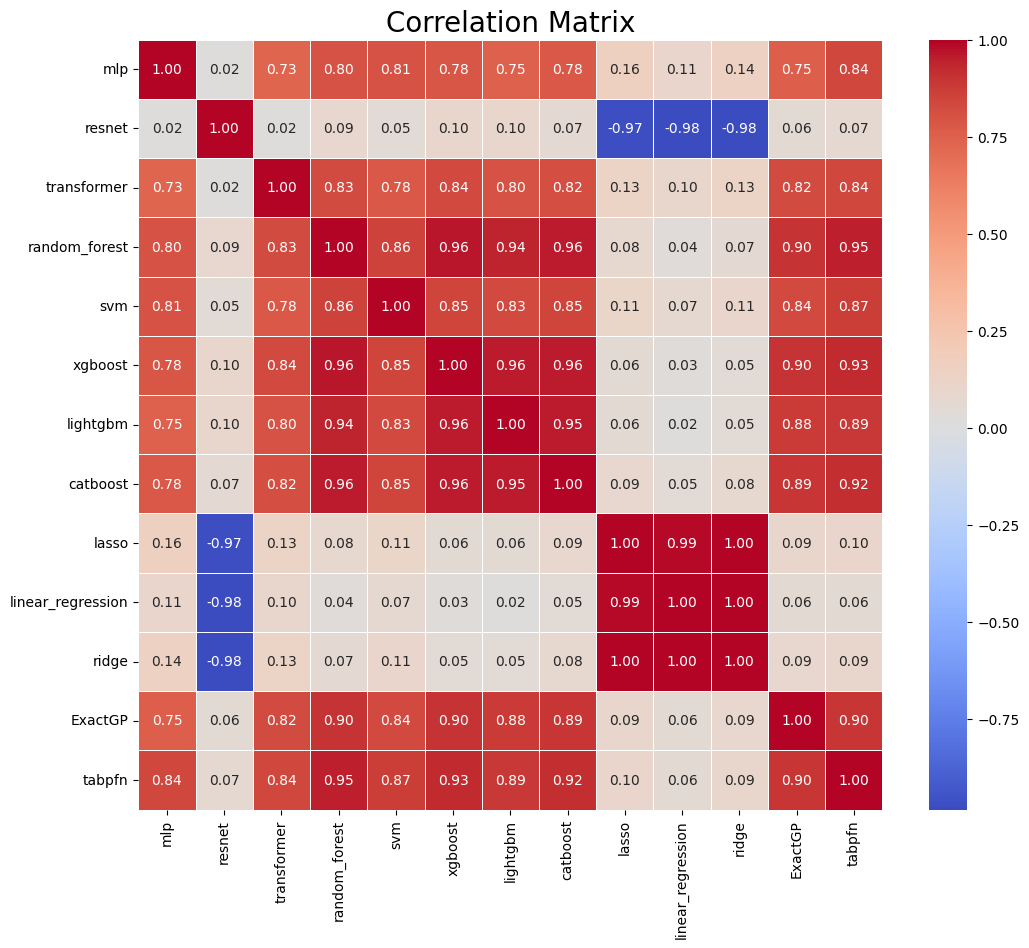

In [37]:
# correlation matrix
correlation_matrix = training_predictions.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar=True)

# Adjustments for aesthetics
plt.title('Correlation Matrix', fontsize=20)
plt.show()

In [38]:
meta_model = xgb.XGBRegressor(random_state=42)
meta_model.fit(training_predictions, train_labels)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [39]:
# Make predictions
meta_train_predictions = meta_model.predict(training_predictions)
meta_test_predictions = meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.4f}")


Training Metrics:
MAE: 0.0084
MAPE: 94.0919%
RMSE: 0.0206
R2: 0.9961

Test Metrics:
MAE: 0.1495
MAPE: 125.3903%
RMSE: 0.2242
R2: 0.5610


In [40]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': sheet_names,
    'Importance': meta_model.feature_importances_
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

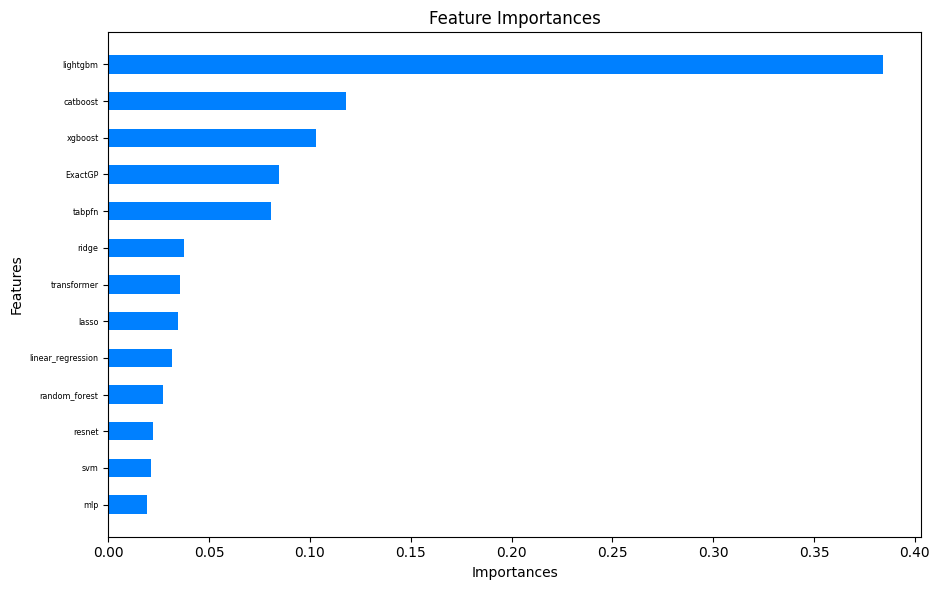

In [41]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()

RIDGE AS META-LEARNER

In [42]:


# Train the final model on the entire training data
ridge_meta_model = Ridge(random_state=42)

ridge_meta_model.fit(training_predictions, train_labels)


Ridge(random_state=42)

In [47]:
# Make predictions
meta_train_predictions = ridge_meta_model.predict(training_predictions)
meta_test_predictions = ridge_meta_model.predict(test_predictions)

# Calculate and print metrics
train_metrics = calculate_metric(meta_train_predictions, train_labels.values.ravel())
test_metrics = calculate_metric(meta_test_predictions, test_labels.values.ravel())

print("\nTraining Metrics:")
print(f"MAE: {train_metrics[0]:.4f}")
print(f"MAPE: {train_metrics[1]:.4f}%")
print(f"RMSE: {train_metrics[2]:.4f}")
print(f"R2: {train_metrics[3]:.4f}")

print("\nTest Metrics:")
print(f"MAE: {test_metrics[0]:.4f}")
print(f"MAPE: {test_metrics[1]:.4f}%")
print(f"RMSE: {test_metrics[2]:.4f}")
print(f"R2: {test_metrics[3]:.5f}")


Training Metrics:
MAE: 0.3371
MAPE: 4651.7874%
RMSE: 0.2169
R2: 0.5663

Test Metrics:
MAE: 0.3482
MAPE: 394.0612%
RMSE: 0.2126
R2: 0.60537


In [44]:
non_zero_coeff = []
non_zero_features = []
coef = ridge_meta_model.coef_
for index, value in enumerate(coef.ravel()):
    if value == 0:
        continue
    non_zero_coeff.append(value)
    non_zero_features.append(sheet_names[index])

In [45]:
### Feature importance 

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': non_zero_features,
    'Importance': non_zero_coeff
})

# Sort the features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=True)

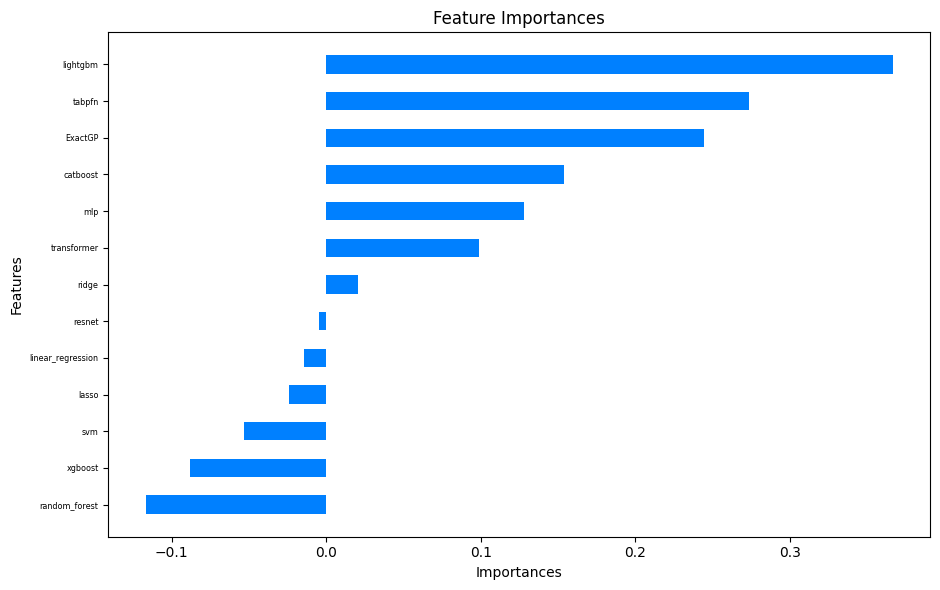

In [46]:
# Create a horizontal bar chart
plt.figure(figsize=(10, 6))  # Adjust the size of the plot as needed
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color=(0, 0.5, 1), height=0.5)  # Adjust the height for spacing

plt.ylabel('Features')  # Label for the y-axis
plt.xlabel('Importances')  # Label for the x-axis
plt.title('Feature Importances')  # Title of the plot
plt.tight_layout()  # Automatically adjust subplot parameters to give specified padding
plt.yticks(fontsize='xx-small')

plt.show()